<a href="https://colab.research.google.com/github/shere-khan/machine_learning/blob/master/PyTorchMlpMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [ ]:
# most values of image will be 0s because the images
# are mostly black except for the white pixels
# corresponding to the actual digits
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(), # ToTensor normalizes the data
    download=True
)

In [ ]:
# Build the model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
# No need for final softmax because it's been
# combined with the cross entropy loss for
# numerical stability

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device) # tranfers all model parameters to the gpu

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)


In [ ]:
# check out what the data loader does
# maps the values to (0, 1)
# makes the data of shape (batch size, color, height, width)
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)

for x, y in tmp_loader:
  print(x)
  print(x.shape)
  print(y.shape)
  break


In [ ]:
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

In [ ]:
# train the model
n_epochs = 10

# stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 784)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  # get train loss and test loss
  train_loss = np.mean(train_loss) # not the loss for epoch

  # calculate test loss
  # we can't calculate loss all at once because all of
  # test data might not fit into memory
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  print(f"""Epoch {it + 1} / {n_epochs}, 
  TrainLoss: {loss.item():.4f}, TestLoss: {test_loss}""")

Epoch 1 / 10, 
  TrainLoss: 0.0632, TestLoss: 0.2179981786168263
Epoch 2 / 10, 
  TrainLoss: 0.0351, TestLoss: 0.1565420399007352
Epoch 3 / 10, 
  TrainLoss: 0.0309, TestLoss: 0.1293470100647051
Epoch 4 / 10, 
  TrainLoss: 0.0077, TestLoss: 0.10607803829273657
Epoch 5 / 10, 
  TrainLoss: 0.0059, TestLoss: 0.09401618649216392
Epoch 6 / 10, 
  TrainLoss: 0.0037, TestLoss: 0.08649315722168813
Epoch 7 / 10, 
  TrainLoss: 0.0020, TestLoss: 0.08813077394623615
Epoch 8 / 10, 
  TrainLoss: 0.0023, TestLoss: 0.07908482885738258
Epoch 9 / 10, 
  TrainLoss: 0.0020, TestLoss: 0.07480194081723265
Epoch 10 / 10, 
  TrainLoss: 0.0004, TestLoss: 0.07534123617305444


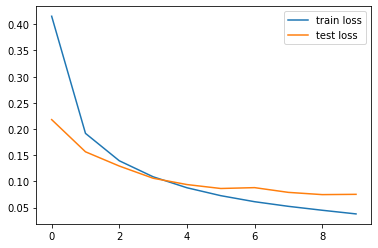

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  #reshape the input
  inputs = inputs.view(-1, 784)

  # forward pass
  outputs = model(inputs)

  # get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total
                  
n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  #reshape the input
  inputs = inputs.view(-1, 784)

  # forward pass
  outputs = model(inputs)

  # get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f'train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

train acc: 0.9928, test acc: 0.9779
